In [10]:
# imports

import xarray as xr  # used to manipulate data and open datasets
import numpy as np  # used for algeba and array operations
import matplotlib.pyplot as plt  # used for plotting
from scipy.optimize import (
    brentq,
)  # used for numerical root-finding to get the equilibria

In [11]:
# @title Figure ettings
import ipywidgets as widgets  # interactive display

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(
#     "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
# )

# Ice-Albedo Feedback

## Temperature Dependent Albedo

Our current model only contains one feedback, the ‘Planck feedback’ also called the ‘Planck temperature response’. This feedback encapsulates that a warming of Earth leads to the planet emitting more energy (see Planck’s law from Tutorial 1). In reality, there are many climate feedbacks that contribute to the Earth’s net temperature change due to an energy imbalance. In this tutorial we will focus on incorporating an ice-albedo feedback into our model.

When earth’s surface warms, snow and ice melt. This lowers the albedo (
), because less solar radiation is reflected off Earth’s surface. This lower albedo causes the climate to warm even more than if the albedo had stayed the same, increasing the snow and ice melt. This is referred to as a positive feedback. Positive feedbacks amplify the changes that are already occurring. This particular feedback is referred to as the ice-albedo feedback.

A simple way to parameterize ice-albedo feedback in our model is through a temperature dependent albedo, such as the one defined below (see the tutorial lecture slides for an explanation of why we use this function).



$$
    \alpha = 
\begin{cases}
    0.1 & T> 300K\\
    0.1 +(0.7 -0.1) \frac{(T-300)^2}{(240-300)^2} & 240 \leq T \leq 300\\
    0.7& T< 240
\end{cases}
$$



Using this new temperature-dependent albedo, we can plot the graphs of absorbed shortwave radiation (ASR) and outgoing longwave radiation (OLR):



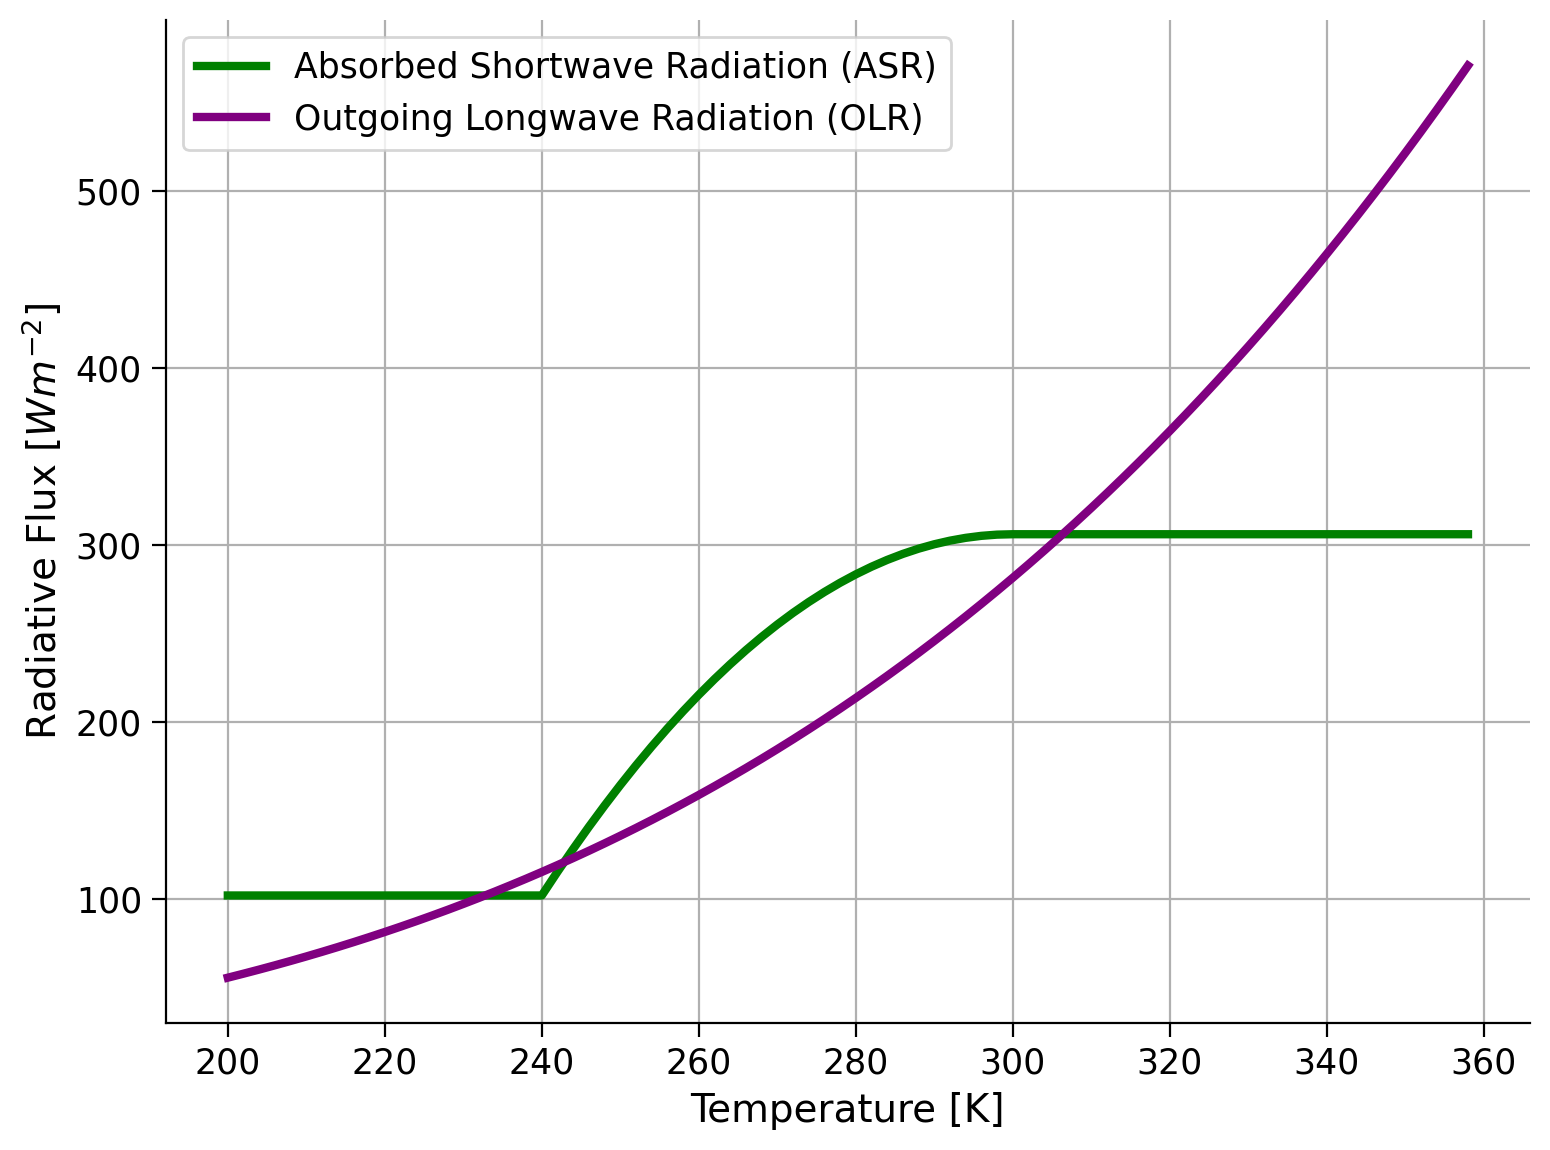

In [21]:
# create a array ot temperatures to evaluates the ASR and OLR at
T = np.arange(200, 360, 2, dtype=np.float64)

# create empty arrays to fill with values later
ASR_vals = np.zeros_like(T)

# define the slope of the ramp function
m = (0.7 - 0.3) / (280 - 250)

# define the observed insolation based on observations from the IPCC AR6 Figure 7.2
Q = 340  # W m^-2

# define transmissivity (calculated previously from observations in tutorial 1)
tau = 0.6127  # unitless number between 0 and 1

# define a function for absorbed shortwave radiation (ASR)
def ASR(Q, T):
    # define function for albedo
    if T >= 300:  # temperature of very warm and ice free earth.
        alpha = 0.1  # average albedo of land and sea without ice
    elif T > 240:  # temperature of Earth to sustain permafrost and sea ice everywhere.
        alpha = 0.1 + (0.7 - 0.1) * (T - 300) ** 2 / (240 - 300) ** 2
    else:
        alpha = 0.7  # average albedo of land and sea ice
    return (1 - alpha) * Q


# define a function for outgoing longwave raditation (OLR)
def OLR(tau, T):
    # define the Stefan-Boltzmann Constant, noting we are using 'e' for scientific notation
    sigma = 5.67e-8  # W m^-2 K^-4

    return tau * sigma * T**4


# calculate OLR for different values of T
OLR_vals = OLR(tau, T)

# calculate ASR for different values of T
for tt, temp in enumerate(T):
    ASR_vals[tt] = ASR(Q, temp)

# make plots
fig, ax = plt.subplots()
ax.plot(T, ASR_vals, label="Absorbed Shortwave Radiation (ASR)", lw=3, color ='green')
ax.plot(T, OLR_vals, label="Outgoing Longwave Radiation (OLR)", lw=3, color ='purple')

ax.set_title("", fontsize=16)
ax.set_xlabel("Temperature [K]", fontsize=14)
ax.set_ylabel("Radiative Flux [$W m^{-2}$]", fontsize=14)
ax.grid()
ax.legend()

How many times do the graphs of ASR and OLR intersect?

What does this intersection mean in terms of Earth’s energy (im)balance?

"""
1. Three.
2. When the graphs intersect, it means that ASR = OLR, and thus ASR-OLR = 0. These three intersections are the three temperatures for which energy balance is satisfied in our model.
""";

# Multiple Equilibria From Graphs

Equilibrium temperatures are solutions to the model equation when the rate of change of temperature is zero. There are two types of equilibrium solutions: stable and unstable.

A stable equilibrium temperature is a solution that the model asymptotes to (moves towards) over time.

An unstable equilibrium temperature is a solution that the model diverges (moves away) from over time. The only time the model will stay at this equilibrium is if it starts exactly at the unstable equilibrium temperature.

We can now incorporate the temperature-dependent albedo we defined above into our time-dependent model from Tutorial 3, to investigate the impact of the ice-albedo feedback on the long-term behavior temperature.

In [12]:
# create a function to find the new temperature based on the previous using Euler's method.
def step_forward(T, tau, Q, dt):

    # define the heat capacity (calculated in Tutorial 3)
    C = 286471954.64  # J m^-2K

    T_new = T + dt / C * (ASR(Q, T) - OLR(tau, T))

    return T_new

Let us explore how our model behaves under a variety of initial temperatures. We can use a for loop compare different initial temperatures.

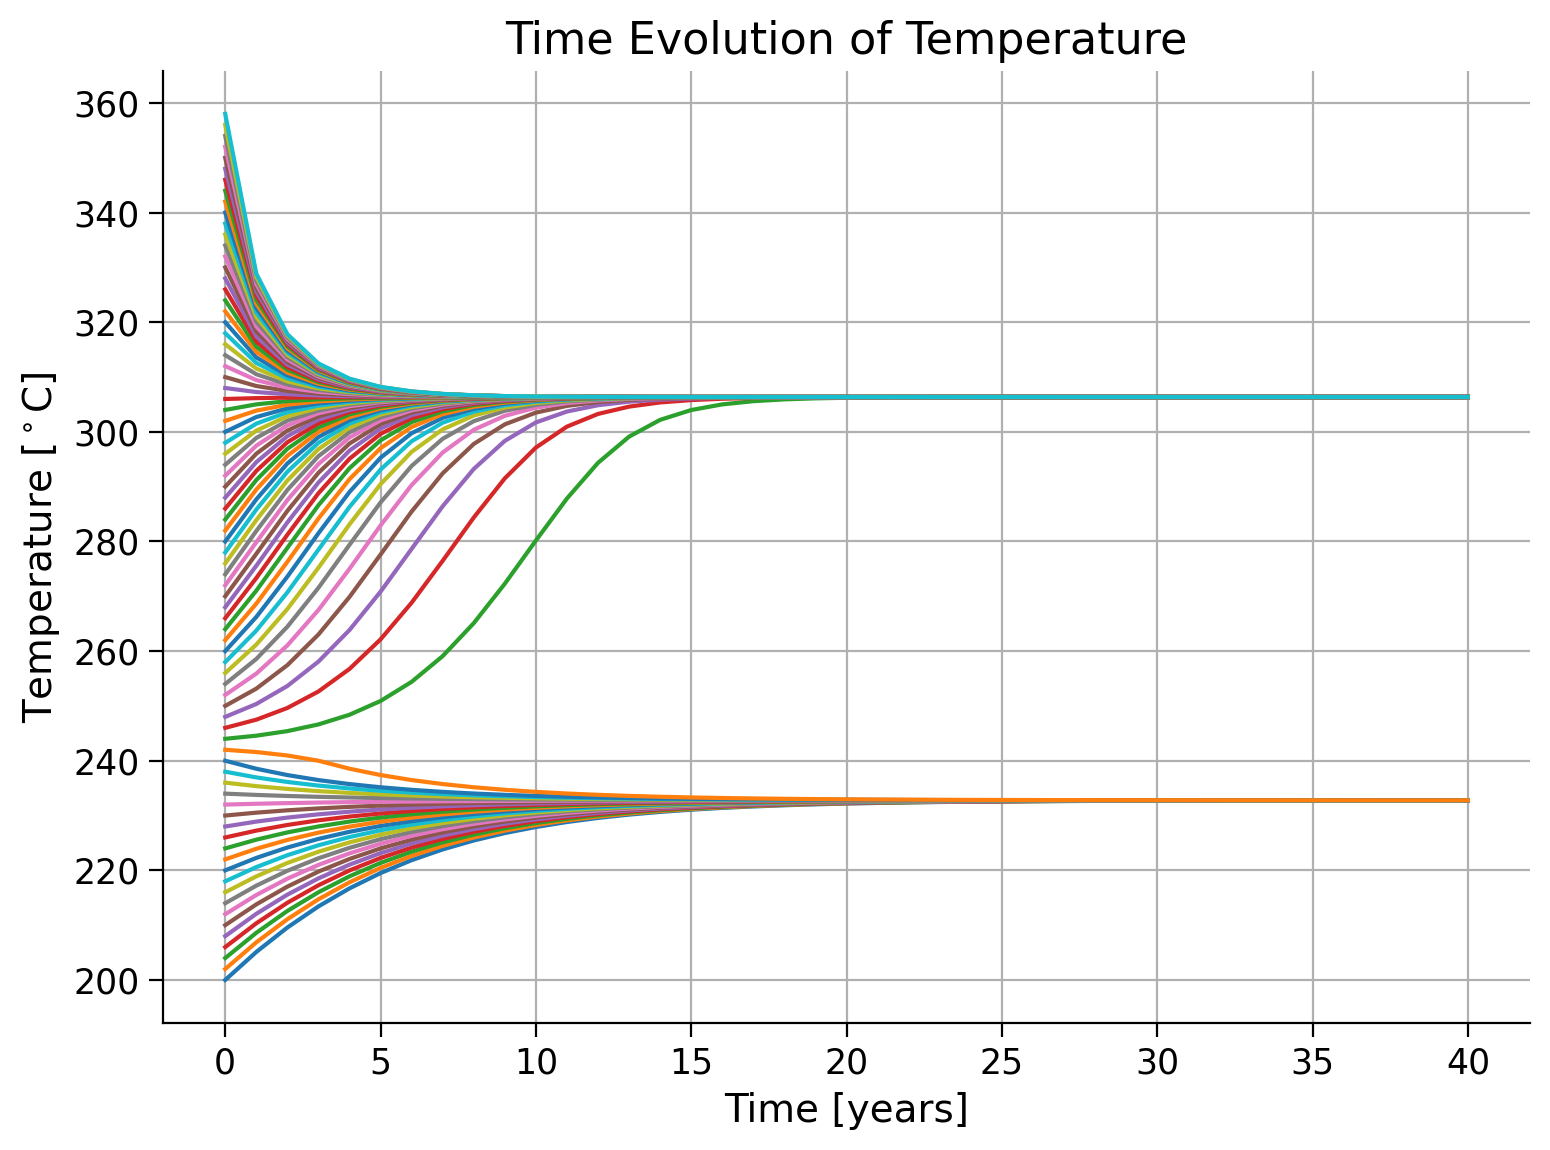

In [25]:
dt = 60.0 * 60.0 * 24.0 * 365.0  # time interval, one year expressed in seconds

fig, ax = plt.subplots()
for init_temp in T:  # suite of intial temperatures in K
    numtsteps = 40  #  number of years to run the model

    # for converting number of seconds in a year
    sec_2_yr = 3.154e7

    # set the intial temperature (initial condition)
    T_series = [init_temp]

    # set the initial time to 0
    t_series = [0]

    # run the model
    for n in range(numtsteps):

        # calculate and append the time since running the model, dependent on dt and the numtsteps
        t_series.append((n + 1) * dt / sec_2_yr)

        # calculate and append the new temperature using our pre-defined function
        T_series.append(step_forward(T_series[n], tau=tau, Q=Q, dt=dt))

    # make plot
    ax.plot(t_series, T_series)

ax.set_title("Time Evolution of Temperature", fontsize=16)
ax.set_xlabel("Time [years]", fontsize=14)
ax.set_ylabel("Temperature [$^\circ$C]", fontsize=14)
ax.grid()

1. How many stable equilibria can you find on the figure above? Estimate their values.

2. What do these values represent on the figure you made in Part 1?

3. There is an unstable equilibrium state within this model. What is it’s value?


"""
1. Two. Near 235 K and 305K.
2. They are the  first and third temperatures at which the the ASR and OLR curves intersect, or energy balance is achieved.
3. Near 245K.
""";

# Finding Equilibria Numerically & Determining Convergence or Divergence

To verify the equilibrium solutions we identified graphically in the previous section, we can use python to find the exact values (i.e., where the rate of change in temperature is zero). That is find the temperatures that satisfy

$$
0 = ASR-OLR
$$


To aid us, we will use brentq, a root-finding function from the scipy package.

In [14]:
# create function to find the forcing at the top of the atmosphere
def Ftoa(T):
    return ASR(Q, T) - OLR(tau, T)


#  it requires a function and two end-points be input as arguments
#  it will look for a zero of the function between those end-points
Teq1 = brentq(
    Ftoa, 200.0, 240.0
)  # these ranges are from the intersections of the graphs of ASR and OLR
Teq2 = brentq(Ftoa, 240.0, 280.0)
Teq3 = brentq(Ftoa, 280.0, 320.0)

print(Teq1, Teq2, Teq3)

232.77820135617048 242.83054107162232 306.3533415866786


To assess the stability of these equilibria, we can plot the difference in ASR and OSR. This is the same function (Ftoa) that we calculated in the previous cell, but we will recaclulate it below for plotting purposes

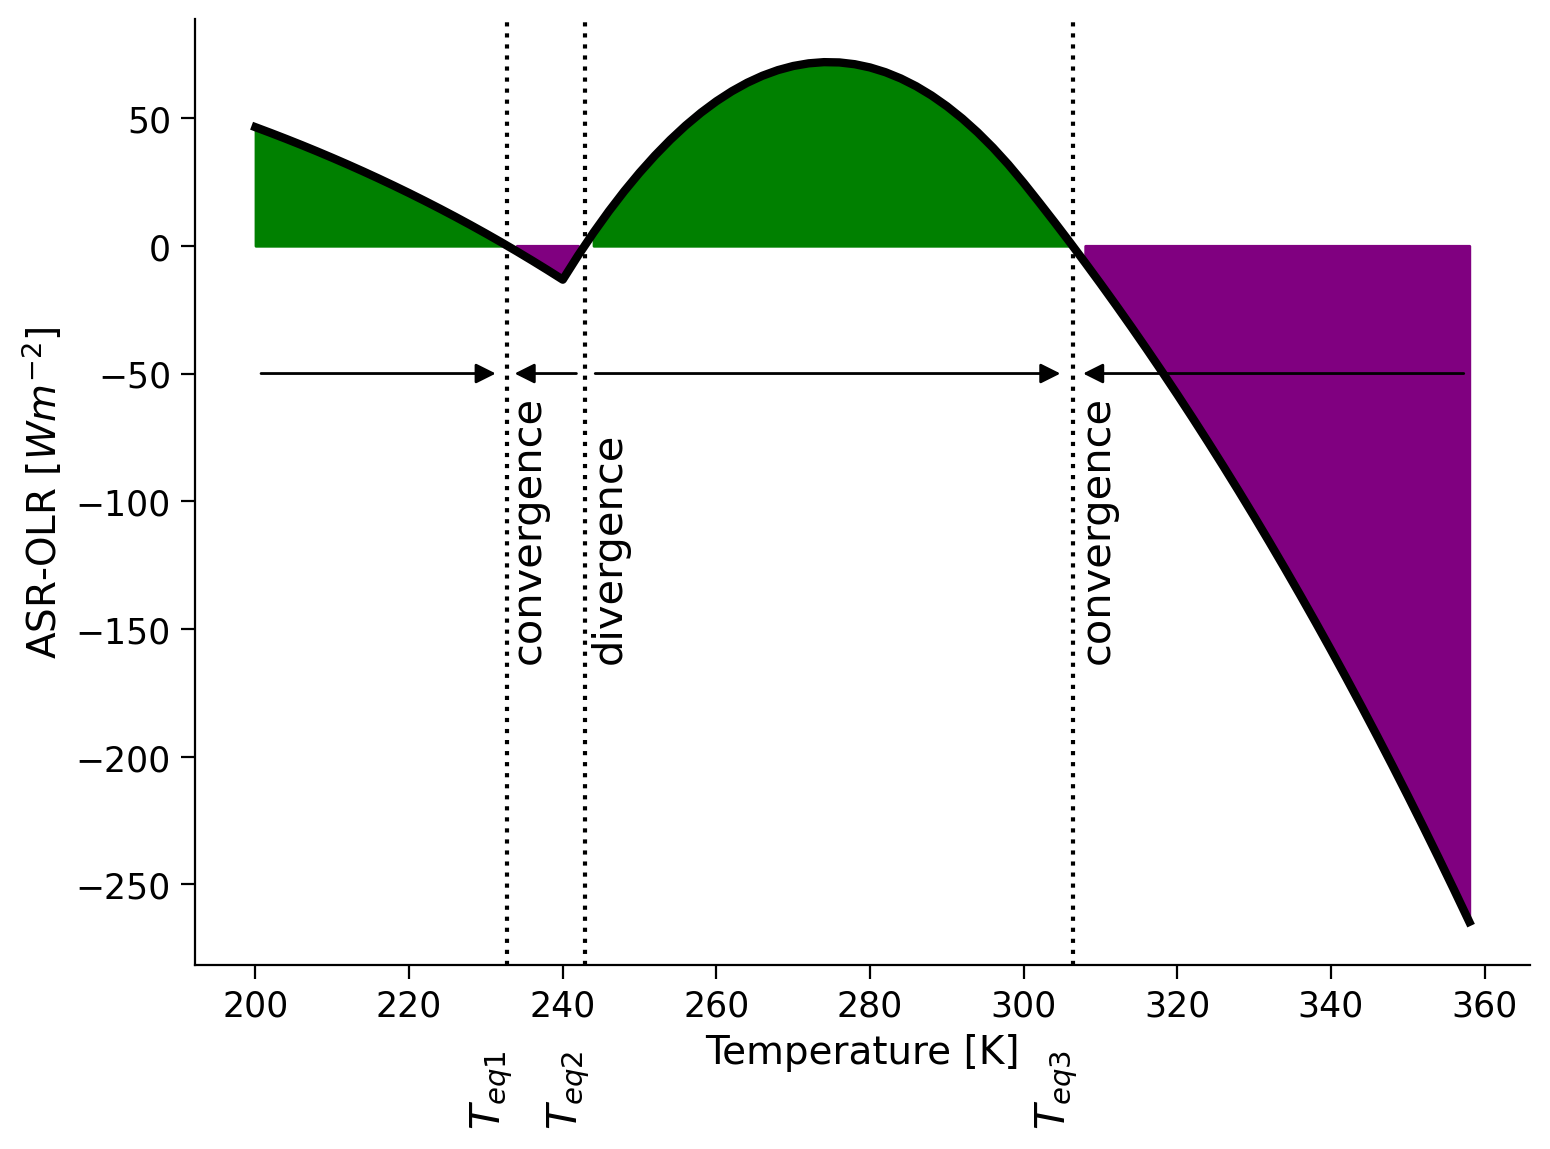

In [30]:
# we've already calculated ASR and OLR above
fig, ax = plt.subplots()
F = ASR_vals - OLR_vals
ax.plot(T, F, color="k", linewidth=3)

# find positive values and fill with red
pos_ind1 = T <= Teq1
ax.fill_between(T[pos_ind1], 0, F[pos_ind1], color="green")

pos_ind2 = (T >= Teq2) & (T <= Teq3)
ax.fill_between(T[pos_ind2], 0, F[pos_ind2], color="green")

# find negative values and fill with blue
neg_ind1 = (T >= Teq1) & (T <= Teq2)
ax.fill_between(T[neg_ind1], 0, F[neg_ind1], color="purple")

neg_ind2 = T >= Teq3
ax.fill_between(T[neg_ind2], 0, F[neg_ind2], color="purple")

# plot vertical lines/names at equilibrium temperatures
ax.axvline(x=Teq1, color="k", ls=":")
ax.axvline(x=Teq2, color="k", ls=":")
ax.axvline(x=Teq3, color="k", ls=":")

ax.annotate(
    "$T_{eq1}$",
    xy=(Teq1 - 5, -340),
    xytext=(Teq1 - 5, -340),
    rotation=90,
    annotation_clip=False,
)
ax.annotate(
    "$T_{eq2}$",
    xy=(Teq2 - 5, -340),
    xytext=(Teq2 - 5, -340),
    rotation=90,
    annotation_clip=False,
)
ax.annotate(
    "$T_{eq3}$",
    xy=(Teq3 - 5, -340),
    xytext=(Teq3 - 5, -340),
    rotation=90,
    annotation_clip=False,
)

# plot arrows/text to show stability of equilibrium points
ax.annotate(
    "",
    xy=(232, -50),
    xytext=(200, -50),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)

ax.annotate(
    "",
    xy=(242.5, -50),
    xytext=(233, -50),
    arrowprops=dict(facecolor="black", arrowstyle="<|-"),
)

ax.annotate(
    "",
    xy=(305.5, -50),
    xytext=(243.5, -50),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)

ax.annotate(
    "",
    xy=(358, -50),
    xytext=(307, -50),
    arrowprops=dict(facecolor="black", arrowstyle="<|-"),
)


ax.annotate("convergence", xy=(358, -160), xytext=(307, -160), rotation=90)

ax.annotate("divergence", xy=(305.5, -160), xytext=(243.5, -160), rotation=90)

ax.annotate("convergence", xy=(242.5, -160), xytext=(233, -160), rotation=90)


ax.set_xlabel("Temperature [K]", fontsize=14)
ax.set_ylabel("ASR-OLR [$W m^{-2}$]", fontsize=14);
#ax.grid()

The red regions represent conditions where the Earth would warm, because the energy absorbed by the Earth system is greater than the energy emitted or reflected back into space.

The blue regions represent conditions where the Earth would cool, because the outgoing radiation is larger than the absorbed radiation.

For example, if Earth started at an initial temperature below $T_{eq1}$
 (in the left red region), it will move to the right on the 
$x$-axis, towards the $T_{eq1}$
 equilibrium state. Conversely, if Earth started between $T_{eq1}$
 and $T_{eq2}$
 (the left blue region), the temperature would decrease, moving left on the 
$x$-axis until it reaches $T_{eq1}$
. Thus $T_{eq1}$
 is a stable equilibrium as the temperature curves will tend to this point after a long time.
 
 
 
 
 1. Identify the stable and unstable equilibria from this graph. Do these agree with the figure you made in Section 1.2?
 
 
 
 
 
 1. Two stable equilibria (near 235 K and 305K) and one unstable equilibrium (near 245 K). Yes they do.

# Section 2: Changing Insolation
## Section 2.1: Effect on the Number Equilibrium Solutions
During Day 1 of this week, you learned that insolation (the amount of radiation Earth receives from the sun at the top of the atmosphere) fluctuates with time. Over Earth’s history, the insolation has sometimes been lower, and sometimes been higher, than the currently observed $340 Wm^{-2}$
.

These insolation changes directly affect the ASR, causing Earth to warm or cool depending on whether it receives more or less insolation respectively. To look at the effect that changing insolation has on Earth’s equilibrium state(s), we can re-plot ASR as a function of temperature for several different insolation values (including the temperature-dependent albedo), alongside the OLR.

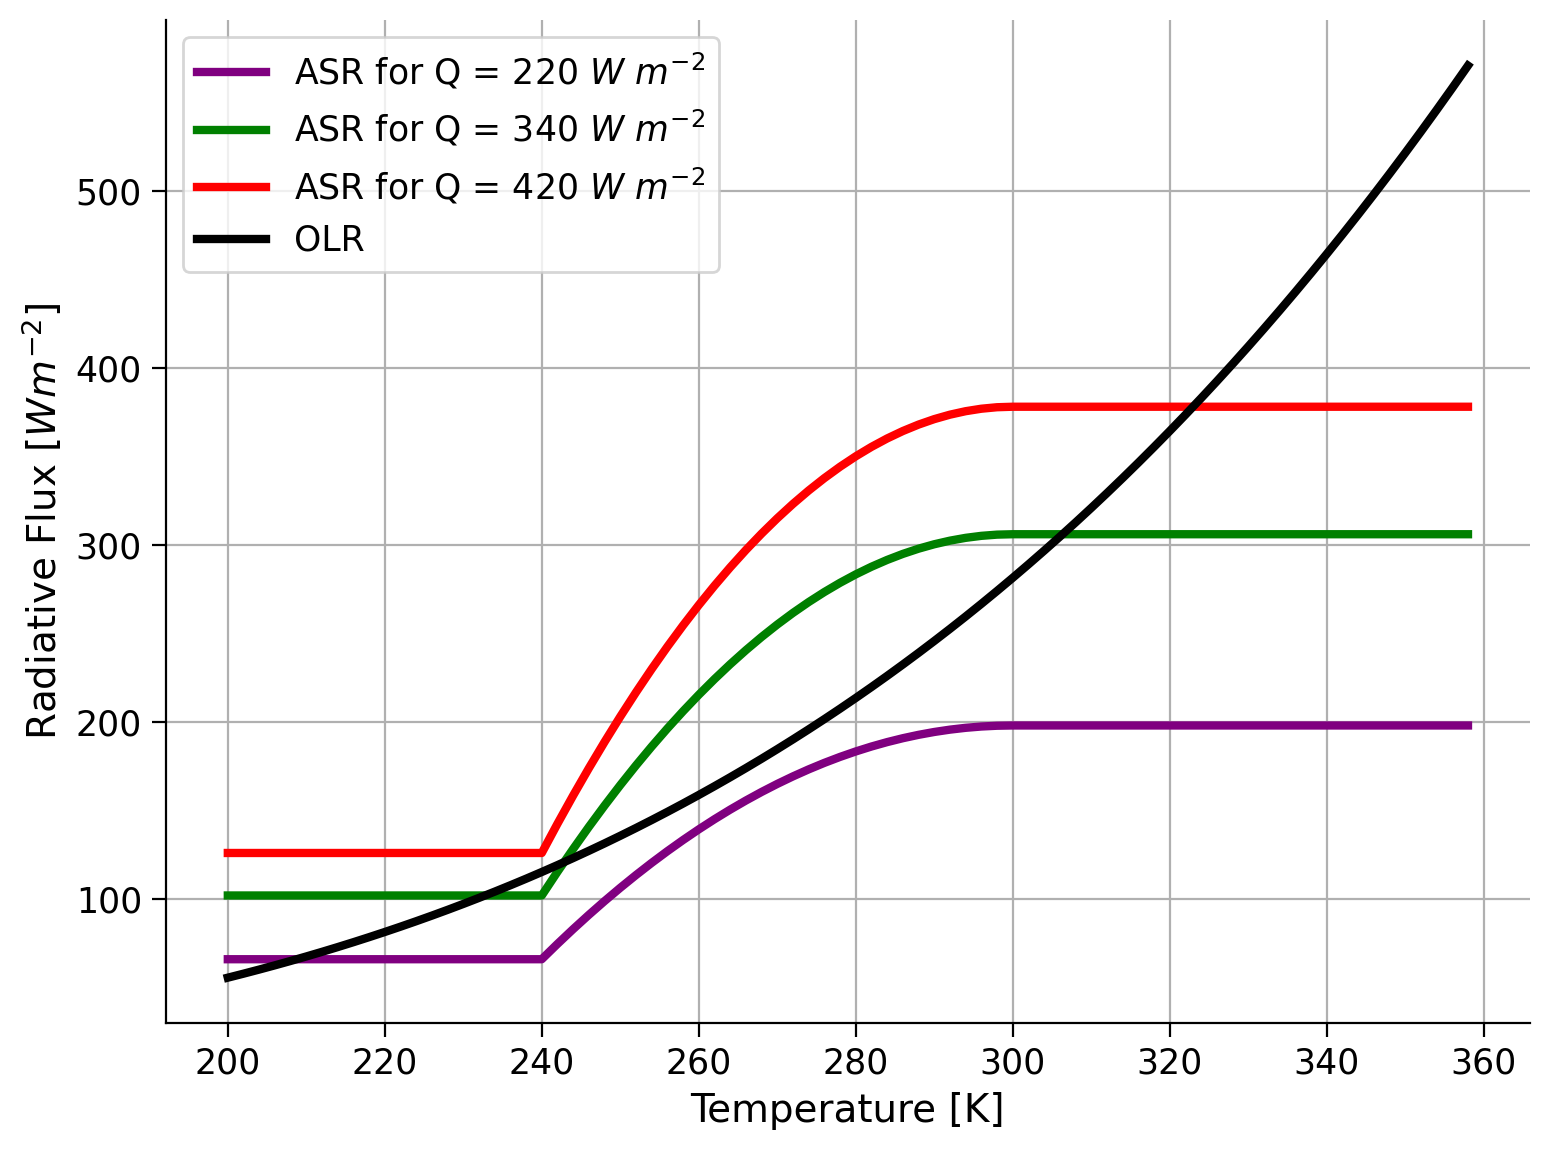

In [33]:
# define the observed insolation
Q_vals = [220, 340, 420]  # W m^-2
colors = ['purple','green','red']

fig, ax = plt.subplots()
for i in range(len(Q_vals)):
    # calculate ASR and OLR for different values of T
    for tt, temp in enumerate(T):

        ASR_vals[tt] = ASR(Q_vals[i], temp)

    # make plots
    ax.plot(T, ASR_vals, lw=3, label="ASR for Q = " + str(Q_vals[i]) + " $W$ $m^{-2}$",color =colors[i])

# note we calculated OLR previously, and it does not depend on Q
ax.plot(T, OLR_vals, lw=3, label="OLR",color ='k')

ax.set_title("", fontsize=16)
ax.set_xlabel("Temperature [K]", fontsize=14)
ax.set_ylabel("Radiative Flux [$W m^{-2}$]", fontsize=14);
ax.grid()
ax.legend()


As we increase or decrease the insolation, the number of intersections between ASR and OLR can change! This means the number of equilibrium solutions for our model will also change.



1. How many stable equilibrium solutions are there when $Q = 220 W m^{-2}$? Warm (ice-free) or cold (completely-frozen) state(s)?

2. For $Q = 420 W m^{-2}$? Warm or cold equilibrium state(s)?


"""
1. One, cold.
2. One, warm.

# Section 2.2: Effect on Equilibrium Temperatures
To understand how this effect translates to different equilibrium temperatures of our model over time, we will apply a range of insolation values to our model. Let us first start off with a very cold Earth, at 220 K, and warm the Earth by steadily increasing the insolation above our present day 340 $W m^{-2}$ value.

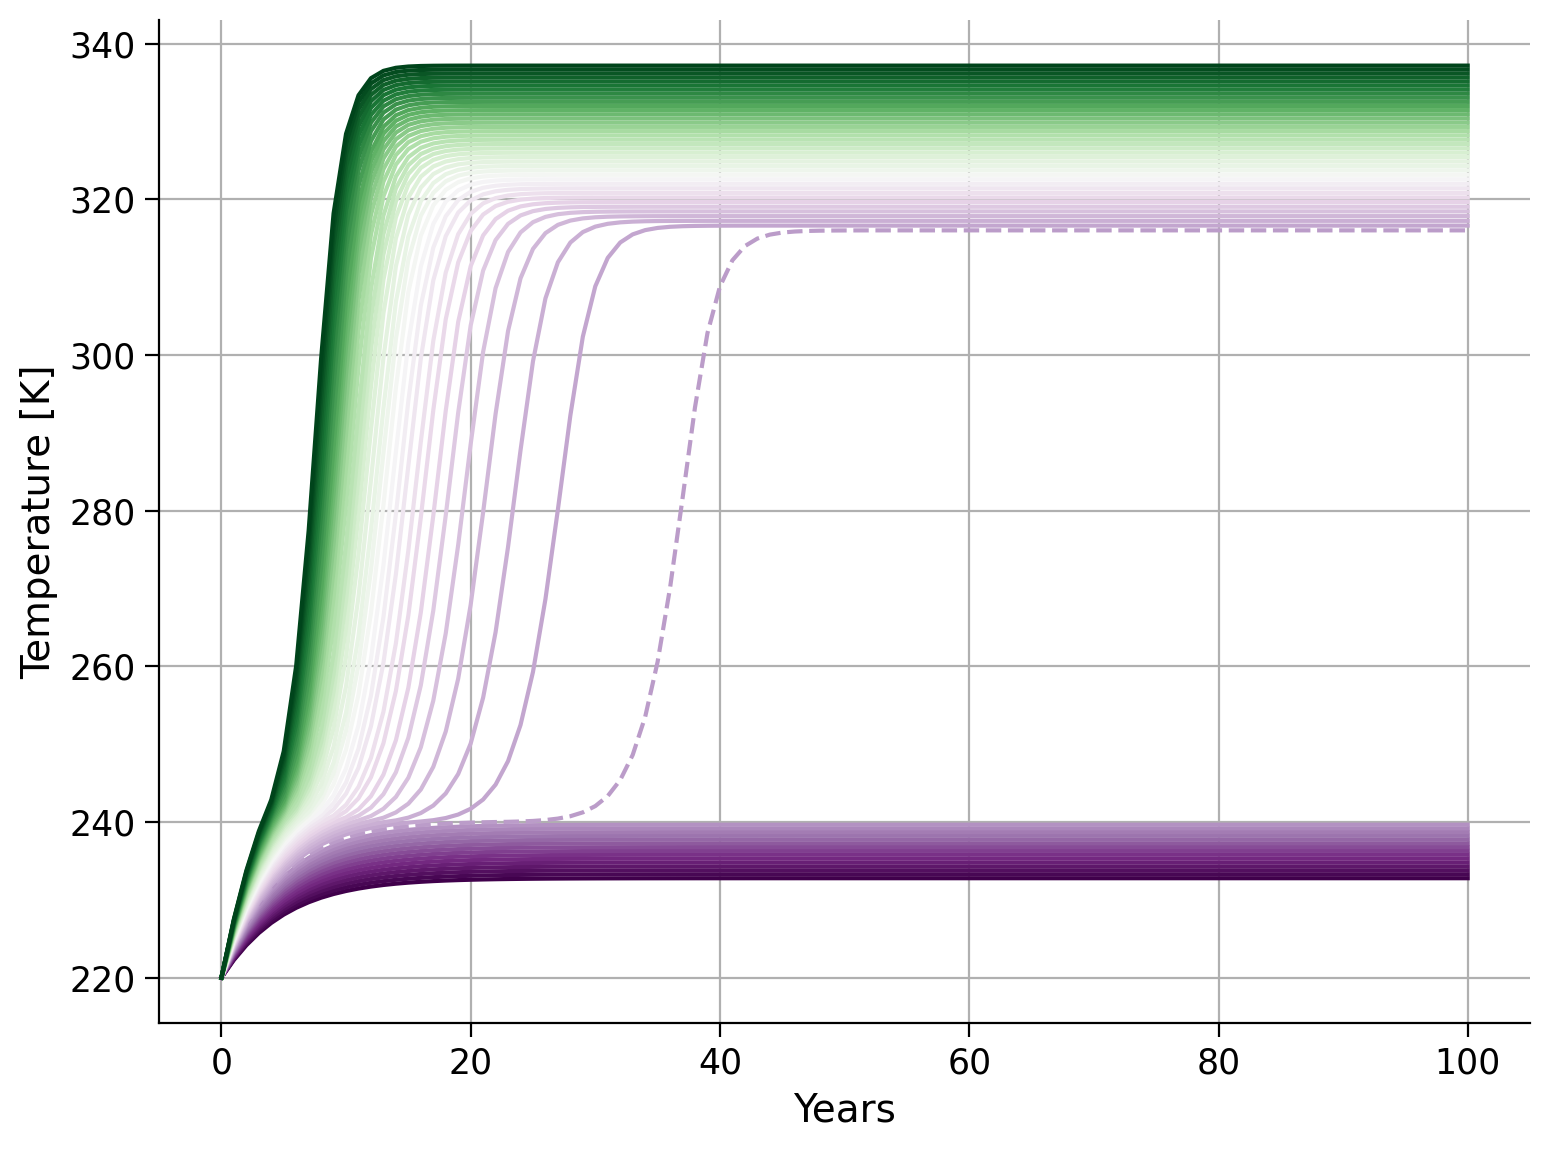

In [35]:
# these are the values of insolation we will use
insolation_vals = np.arange(340, 500, 3)

# initial temperature we will use
init_temp = 220  # K

fig, ax = plt.subplots()

for i, insolation in enumerate(insolation_vals):  # suite of initial temperatures in K

    numtsteps = 100  #  number of years to run the model

    # for converting number of seconds in a year
    sec_2_yr = 3.154e7

    # set the intial temperature (initial condition)
    T_series = [init_temp]

    # set the initial time to 0
    t_series = [0]

    # run the model
    for n in range(numtsteps):

        # calculate and append the time since running the model, dependent on dt and the numtsteps
        t_series.append((n + 1) * dt / sec_2_yr)

        # calculate and append the new temperature using our pre-defined function
        T_series.append(step_forward(T_series[n], tau=tau, Q=insolation, dt=dt))

    # make plot
    colors = plt.cm.PRGn(np.linspace(0, 1, insolation_vals.shape[0]))
    if (
        insolation == 385
    ):  # This is just to highlight a particularly interesting insolation value
        ax.plot(t_series, T_series, color=colors[i], linestyle="dashed")
    else:
        ax.plot(t_series, T_series, color=colors[i])

ax.set_ylabel("Temperature [K]", fontsize=14)
ax.set_xlabel("Years", fontsize=14)
ax.grid()

1. Noting the dashed blue lines, at approximately what temperature do you note a rapid transition from cold to warm equilibrium states? How do these compare to your equation for albedo?

2. How would you interpret the rapid transition in equilibrium temperatures with changing insolation (the big gap in the figure) using the ASR & OLR vs. temperature plot that you made in Section 2.1?

3. BONUS: How does the time-varying behavior of the reddest (warm-state) lines relate to the ice-albedo feedback?


"""
1. The transition occurs around 240K. This is the lower temperature limit at which the ice-albedo feedback would kick in if Earth were warmed from below 240K.
2. Initally, we have a cold equilibrium solution like the blue and orange lines of the figure in Section 2.1, so the model converges to the cold equilibrium temperature. However, as the insolation increases we reach a point where only a warm equilibrium state exists, like the green line. When this happens, the Earth cannot equilibrate in a cold state anymore so Earth's temperature continues rising until it reaches the warm equilibrium state.
3. BONUS: All the systems on this plot start at 220K, where Earth is in a completely frozen state with an albedo of 0.7. Initially as the planet warms, the albedo stays at 0.7, however when the insolation becomes high enough that the planet warms to 240K (i.e. there is no cold equilibrium state) the ice-albedo feedback causes the albedo to begin decreasing, representing the effect of ice & snow melt. This drop in albedo accelerates the warming of the planet over time, as seen in the plot, until Earth reaches its warm equilibrium temperature.
"""

# Summary 


In this tutorial, you learned about stable and unstable equilibria, identifying them from graphs and precisely calculating them. You also incorporated an ice-albedo feedback into your model to observe its effects on equilibrium solutions under varying insolation.